# Fairness Analysis of the UTK FACE Baseline Models

Analysis of the test set with regard to the gender prediction.

In [22]:
from IPython.display import display, Markdown, Latex
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')

colors = ['#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c']



dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    },
    'age_id': {
        0: '<10',
        1: '10-20',
        2: '20-30',
        3: '30-40',
        4: '40-60',
        5: '60-80',
        6: '80+'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())
dataset_dict['age_alias'] = dict((a, i) for i, a in dataset_dict['age_id'].items())

{'race_id': {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}, 'gender_id': {0: 'male', 1: 'female'}, 'age_id': {0: '<10', 1: '10-20', 2: '20-30', 3: '30-40', 4: '40-60', 5: '60-80', 6: '80+'}, 'gender_alias': {'male': 0, 'female': 1}, 'race_alias': {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4}, 'age_alias': {'<10': 0, '10-20': 1, '20-30': 2, '30-40': 3, '40-60': 4, '60-80': 5, '80+': 6}}


In [26]:
# read csv with predictions from the model
predictions_path = r"C:\Users\thoma\Documents\_FAIRALGOS\utk-fairness-analysis\Predictions\df_predctions_all.csv"
df_predictions = pd.read_csv(predictions_path, index_col=0)

# analysis with regard to the gender prediction only -> dropping age and race predictions
df_bld = df_predictions.drop(columns=['age_pred', 'race_pred']).rename(columns={'age_true': 'age', 'race_true': 'race'})

# transforming gender_true and gender_pred into a single attribute if the prediction was correct
pred_true = []
for i, row in df_bld.iterrows():
    if(row['gender_true'] == row['gender_pred']):
        pred_true.append(1)
    else:
        pred_true.append(0)

df_bld['pred_true'] = pred_true
df_bld = df_bld.drop(columns=['gender_pred']).rename(columns={'gender_true': 'gender'})

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
# cutting the age into bins
age_binned = pd.cut(df_bld['age'], bins, labels=[0,1,2,3,4,5,6])
df_bld['age'] = age_binned

  age  race  gender  pred_true
0   2     0       0          0
1   2     4       1          1
2   2     2       1          1
3   2     3       0          1
4   4     0       1          1


## Base rates for all races

<IPython.core.display.Latex object>

white: 0.912
black: 0.915
asian: 0.833
indian: 0.918
others: 0.881


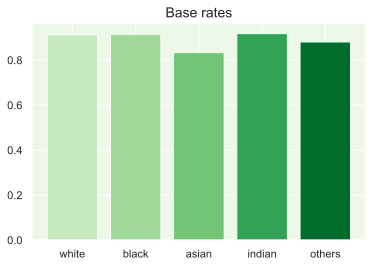

In [27]:
# computing the base rate for race

display(Markdown('## Base rates for all races'))
display(Latex(r'$Pr(Y=1) = \frac{P}{P + N}$'))

races = []
base_rates = []
for race_id in dataset_dict['race_id']:
    race_alias = dataset_dict['race_id'][race_id]
    races.append(race_alias)
    
    num_pos = len(df_bld[(df_bld['race'] == race_id) & (df_bld['pred_true'] == 1)])
    num_neg = len(df_bld[(df_bld['race'] == race_id) & (df_bld['pred_true'] != 1)])
    base_rate = num_pos / (num_pos + num_neg)
    base_rates.append(base_rate)

    print(f'{race_alias}: {np.round(base_rate, 3)}')


sns.set(rc={'axes.facecolor':colors[0], 'figure.facecolor':'white'})
plt.bar(races, base_rates, color=colors[1:])
plt.title("Base rates", fontsize=14)
plt.show()

In [28]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric



bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=['race'])
bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{'race': 2}], privileged_groups=[{'race': 0}])


In [29]:
# fairness metrics

def fairness_summary(bld_metric):
    summary = {'base_rate_priviledged': bld_metric.base_rate(privileged=True),
     'base_rate_unpriviledged': bld_metric.base_rate(privileged=False),
     'consistency': bld_metric.consistency()[0],
     'disparate_impact': bld_metric.disparate_impact(),
     'mean_difference': bld_metric.mean_difference(),
     'smoothed_empirical_differential_fairness': bld_metric.smoothed_empirical_differential_fairness(concentration=1.0)}

    return summary


fairness_summary(bld_metric)

{'base_rate_priviledged': 0.9124500665778962,
 'base_rate_unpriviledged': 0.8334956183057449,
 'consistency': 0.8337784090909054,
 'disparate_impact': 0.9134698421709075,
 'mean_difference': -0.07895444827215126,
 'smoothed_empirical_differential_fairness': 0.7071235548020909}